## Multiclass Classification
### First method: k-nearest neighbours (kNN)
### Second method: Naive Bayess
### Third method: Logistic Regression + Gradient Descent + Regularization

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unittest
import math
import sys
import random
import time

### Time Counting Method

In [2]:
def count_time(f, param_1, param_2, name):  
    start = time.perf_counter()
    res = f(param_1, param_2)
    total = time.perf_counter() - start
    print(f"Time for: {name} => {total}s")
    return res

### Data generatar

In [3]:
# all data
def standard_data_generator(N, noise):
    labels = np.array([[1]]*N + [[2]]*N + [[3]]*N + [[4]]*N)
    data = [random_data(1.5, noise, N), random_data(1.5, noise, N), 
            random_data(0.5, noise, N), random_data(1.5, noise, N),
            random_data(0.5, noise, N), random_data(0.5, noise, N),
            random_data(1.5, noise, N), random_data(0.5, noise, N)]
    conc_data_x1 = np.concatenate([d for d in data[::2]])
    conc_data_x2 = np.concatenate([d for d in data[1::2]])
    return {'x1': conc_data_x1, 'x2':conc_data_x2, 'y': labels}
    
def random_data(a, noise, N):
    rng = random.uniform(noise/2, noise)
    data = np.random.uniform(a - rng, a + rng, size = N)
    return np.array([[d] for d in data])

def totally_random_data_generator(N):
    data_x1 = np.random.uniform(0.1, 1.9,size = N)
    data_x2 = np.random.uniform(0.1, 1.9,size = N)
    return {'x1': data_x1, 'x2': data_x2}

### Error function

In [4]:
def error_function(distribution, y_labels):
    y_labels = y_labels.T[0] - 1
    N, M = np.shape(distribution)
    res = 0
    uniq = np.unique(y_labels).shape[0]
    distribution = np.fliplr(distribution)
    for n in range(N):
        if np.argmax(distribution[n]) != (uniq - 1 - y_labels[n]):
            res += 1
    return res / N

### k-Nearest Neighbours

In [5]:
def knn(train_data, val_data):
    # data
    x1_train = train_data['x1']
    x2_train = train_data['x2']
    y_train = train_data['y']
    x1_val = val_data['x1']
    x2_val = val_data['x2']
    y_val = val_data['y']
    N1 = x1_val.shape[0]
    N2 = x1_train.shape[0]
    
    # model selection
    dists = calculate_distance(x1_val, x2_val, x1_train, x2_train)
    srt = sort_distances(dists, y_train)
    k_values = np.arange(1,N2)
    errs = [error_function(calculate_distribution_knn(srt, k), y_val) for k in k_values]
    return min(errs), k_values[errs.index(min(errs))], errs, k_values

def calculate_distance(x1, x2, x1_train, x2_train):
    N1 = np.shape(x1)[0]
    N2 = np.shape(x1_train)[0]
    dists = np.array([((x1[v, 0] - x1_train)**2 + (x2[v, 0] - x2_train)**2)**(0.5) for v in range(N1)])    
    return dists[:,:,0]

def sort_distances(dists, y_labels):
    return y_labels[dists.argsort(kind='mergesort')][:,:,0]

def calculate_distribution_knn(y_labels, k):
    M = np.unique(y_labels).shape[0]
    res = list()
    for line in y_labels:
        new_row = [0] * M
        for ki in range(k):
            buf = line[ki]
            new_row[buf-1] += 1 / k
        res.append(new_row)
    return np.array(res)

### Naive Bayess - secret ingredient is gaussian distribution

$Y =  \begin{bmatrix}y^{(0)}\\y^{1)}\\...\\y^{(n-1)}\end{bmatrix}, X_{1} =  \begin{bmatrix}x^{(0)}_1\\x^{(1)}_1\\...\\x^{(n-1)}_1\end{bmatrix}, X_{2} =  \begin{bmatrix}x^{(0)}_2\\x^{(1)}_2\\...\\x^{(n-1)}_2\end{bmatrix}$

$\mu_{x,y} =  \frac{1}{n}  \sum_{i:y^{(i)} = y}^{} x^{(i)}_i$

$\sigma^2_{x,y} = \frac{1}{n} \sum_{i:y^{(i)} = y}(x^{(i)} -  \mu_{x,y})$

$p(x_j | y) = \frac{1}{\sqrt{2\pi \sigma^2_{x_j,y}}} \cdot exp-\frac{1}{2}(\frac{(x-\mu_{x_j,y})^2}{\sigma^2_{x_j,y}})$ for j = 0,...,n-1

In [6]:
def a_prioi(y):
    N = np.shape(y)[0]
    M = np.unique(y).shape[0]
    return np.array([(N - np.count_nonzero(y - i)) / N for i in range(1,M+1)])

def calculate_means(x1, x2, y, N_val):
    N = np.shape(x1)[0]
    M = np.unique(y).shape[0]
    buf = [[np.mean(x1[np.nonzero(y == m+1)[0], :]), np.mean(x2[np.nonzero(y == m+1)[0], :])] for m in range(M)]
    res_single = np.array(buf).T    
    return np.tile(res_single, N_val).reshape((2,N_val,M))

def calculate_variance(x1, x2, y, N_val):
    N = np.shape(x1)[0]
    M = np.unique(y).shape[0]
    buf = [[np.var(x1[np.nonzero(y == m+1)[0], :]), np.var(x2[np.nonzero(y == m+1)[0], :])] for m in range(M)]
    res_single = np.array(buf).T    
    return np.tile(res_single, N_val).reshape((2,N_val,M))

def gauss(x1, x2, mean, var):
    x = np.concatenate((x1, x2), axis=1).T
    _, N, M = np.shape(mean)
    distribution = np.ones((2,N,M))
    for m in range(M):
        fst_prt = 1 / (2*math.pi*var[:,:,m])**(0.5)
        powerr = -0.5*((x - mean[:,:,m])**2 / var[:,:,m])
        snd_prt = np.power(math.e, powerr)
        together = fst_prt*snd_prt
        distribution[:,:,m] = together
    return distribution

def p_x_y_nb(guass_distribution):
    return np.prod(guass_distribution,axis=0).T

def calculate_distribution_nb(apriori, p_x_y):
    M, N = p_x_y.shape
    numerator =  p_x_y * np.reshape(apriori, (M,1))
    denumerator = np.tile(np.sum(numerator,axis=0),M).reshape((M,N)) 
    return np.divide(numerator, denumerator)

def naive_bayess(train_data, val_data):
    # data
    x1_train = train_data['x1']
    x2_train = train_data['x2']
    y_train = train_data['y']
    x1_val = val_data['x1']
    x2_val = val_data['x2']
    y_val = val_data['y']
    N1 = x1_val.shape[0]
    N2 = x1_train.shape[0]
    # > learning
    apri = a_prioi(y_train)
    ms = calculate_means(x1_train, x2_train, y_train, N1)
    vs = calculate_variance(x1_train, x2_train, y_train, N1)
    # > calculating
    gau = gauss(x1_val, x2_val, ms, vs)
    p_x_y = p_x_y_nb(gau)
    distri = calculate_distribution_nb(apri, p_x_y)
    return error_function(distri.T, y_val), distri.T

### Logistic Regression + gradient descent

In [28]:
def sigmoid(z):
    return 1/(1+math.e**(-z))
    
def cost_function(xs, ys, theta):
    m = np.shape(xs)[0]
    sig = sigmoid(xs @ theta)
    return -1/m*np.sum(ys * np.log(sig) + (1 - ys) * np.log(1 - sig))

def design_matrix(xs, polynomial):
    m = xs.shape[0]
    x1 = xs[:, 0].reshape((m,1))
    x2 = xs[:, 1].reshape((m,1))
    
    res = np.concatenate((np.ones((m,1)) ,x1, x2, x1*x2, x1**2, x2**2), axis=1)
    #print(res)
    return res

In [39]:
def gd(xs, y, th, alpha, iterations):
    m = xs.shape[0]
    for ii in range(iterations):
        hx = sigmoid(xs@th)
        buf = (hx - y)*xs
        buf = np.sum(buf, axis = 0)
        th = th - alpha/m*buf.reshape(len(buf), -1)
    return th, cost_function(xs, y, th)
    
def design(xs, polynomial):
    m = xs.shape[0]
    x1 = xs[:, 0].reshape((m,1))
    x2 = xs[:, 1].reshape((m,1)) 
    array = np.zeros((m, 1))
    buf = None
    for char in polynomial:
        print(char)
        if char=="0":
            array = np.concatenate((array, np.ones((m,1))), axis=1)
        
        
        elif char == " ":
            array= np.concatenate((array, buf), axis=1)
    
    array = array[:, 1:]
    print(array)
    return array;

x1 = np.array([0.1,0.2,0.3,0.4]).reshape((4,1))
x2 = np.array([0.5,0.6,0.7,0.8]).reshape((4,1))
y = np.array([0,1,1,0]).reshape((4,1))
th = np.array([0.1,0.1,0.1,0.1,0.1,0.1]).reshape((6,1))
x = np.concatenate((x1, x2), axis=1)

design(x, "00000")

0
0
0
0
0
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

# -------------------------------------- Plot #1 Settings--------------------------------------
### Training Data

In [8]:
def plot_training_data_only(data, i, N):
    # settings
    x1_min = 0
    x1_max = 2.01
    x2_min = 0
    x2_max = 2.01
    period = 0.1
    sub = fig.add_subplot(3, 2, i)
    plt.xlabel("X1 Axis", fontsize=10)
    plt.ylabel("X2 Axis", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(x1_min, x1_max)
    sub.set_ylim(x2_min, x2_max)
    sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(x2_min, x2_max, period))
    sub.set_title("Training Data", fontsize=12)
    
    # training data with colors
    sub.plot(data['x1'][:N],data['x2'][:N], 'o', color='red')
    sub.plot(data['x1'][N:2*N],data['x2'][N:2*N], 'x', color='green')
    sub.plot(data['x1'][2*N:3*N],data['x2'][2*N:3*N], '^', color = 'blue')
    sub.plot(data['x1'][3*N:],data['x2'][3*N:], 'v', color = 'yellow')

# -------------------------------------- Plot #2 Settings--------------------------------------
### Validation Data

In [9]:
def plot_validation_data(data_t, data_v, i, N_t, N_v):
    # settings
    x1_min = 0
    x1_max = 2.01
    x2_min = 0
    x2_max = 2.01
    period = 0.1
    sub = fig.add_subplot(3, 2, i)
    plt.xlabel("X1 Axis", fontsize=10)
    plt.ylabel("X2 Axis", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(x1_min, x1_max)
    sub.set_ylim(x2_min, x2_max)
    sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(x2_min, x2_max, period))
    sub.set_title("Validation Data", fontsize=12)
    
    # training data
    sub.plot(data_t['x1'][:N_t],data_t['x2'][:N_t], 'x', color='gray', markersize = 5)
    sub.plot(data_t['x1'][N_t:2*N_t],data_t['x2'][N_t:2*N_t], 'x', color='gray', markersize = 5)
    sub.plot(data_t['x1'][2*N_t:3*N_t],data_t['x2'][2*N_t:3*N_t], 'x', color = 'gray', markersize = 5)
    sub.plot(data_t['x1'][3*N_t:],data_t['x2'][3*N_t:], 'x', color = 'gray', markersize = 5)
    
    # validation data
    sub.plot(data_v['x1'][:N_v],data_v['x2'][:N_v], 'o', color='red')
    sub.plot(data_v['x1'][N_v:2*N_v],data_v['x2'][N_v:2*N_v], 'x', color='green', markersize = 10)
    sub.plot(data_v['x1'][2*N_v:3*N_v],data_v['x2'][2*N_v:3*N_v], '^', color = 'blue')
    sub.plot(data_v['x1'][3*N_v:],data_v['x2'][3*N_v:], 'v', color = 'yellow')

# -------------------------------------- Plot #3 Settings--------------------------------------
### kNN - Error Function For Some *k* Values

In [10]:
def plot_knn_errors(data_t, data_v, i):
    # knn call
    min_err, best_k, errs, k_values = count_time(knn, data_t, data_v, "kNN")

    # settings
    sub = fig.add_subplot(3, 2, i)
    plt.xlabel("*k* Values", fontsize=10)
    plt.ylabel("Error Values", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(min(k_values), max(k_values))
    sub.set_ylim(0, 1)
    #sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(0, 1.01, 0.1))
    sub.set_title(f"kNN Error Function\nMin. err. = {min_err}\nBest *k* = {best_k}", fontsize=12)
    sub.plot(k_values, errs)    

# -------------------------------------- Plot #4 Settings--------------------------------------
### Naive Bayess - Uses Gaussian Distribution

In [11]:
def plot_naive_bayess(data_t, data_v, i):
    # naive bayess call
    error, distri = count_time(naive_bayess, data_t, data_v, "Naive Bayess")
    labels = np.argmax(distri,axis=1)
    
    # data segregation
    red = list()
    red2 = list()
    green = list()
    green2 = list()
    blue = list()
    blue2 = list()
    yellow = list()
    yellow2 = list()
    x1_val = data_v['x1']
    x2_val = data_v['x2']
    y_val = data_v['y']
    N = x1_val.shape[0]
    for n in range(N):
        if labels[n] == 0:
            red.append(x1_val[n,0])
            red2.append(x2_val[n,0])
        elif labels[n] == 1:
            green.append(x1_val[n,0])
            green2.append(x2_val[n,0])
        elif labels[n] == 2:
            blue.append(x1_val[n,0])
            blue2.append(x2_val[n,0])
        elif labels[n] == 3:
            yellow.append(x1_val[n,0])
            yellow2.append(x2_val[n,0])

    # settings
    x1_min = 0
    x1_max = 2.01
    x2_min = 0
    x2_max = 2.01
    period = 0.1
    sub = fig.add_subplot(3, 2, i)
    plt.xlabel("X1 Axis", fontsize=10)
    plt.ylabel("X2 Axis", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(x1_min, x1_max)
    sub.set_ylim(x2_min, x2_max)
    sub.set_xticks(np.arange(x1_min, x1_max, period))
    sub.set_yticks(np.arange(x2_min, x2_max, period))
    sub.set_title(f"Naivee Bayess Prediction\nError Value: {error}", fontsize=12)
    
    # training data
    sub.plot(np.array(red), np.array(red2), 'o', color='red')
    sub.plot(np.array(green), np.array(green2), 'x', color='green')
    sub.plot(np.array(blue), np.array(blue2), '^', color = 'blue')
    sub.plot(np.array(yellow), np.array(yellow2), 'v', color = 'yellow')
    
    
    # displayg the ones that were wrong predicted
    true_ys = data_v["y"]
    all_xs = np.concatenate((data_v["x1"], data_v["x2"]), axis=1)
    indexes = np.nonzero(labels != (true_ys.T-1))[1]
    diff = all_xs[indexes, :]
    sub.plot(diff[:,0], diff[:,1], 'o', color = 'black',fillstyle='none',markersize=20)

# -------------------------------------- Plot #5 Settings--------------------------------------
### Logicla Regression + Gradient Descent

# ------------------------------------------- All Plots -------------------------------------------

Time for: kNN => 2.2288322000000003s
Time for: Naive Bayess => 0.0010522000000001697s


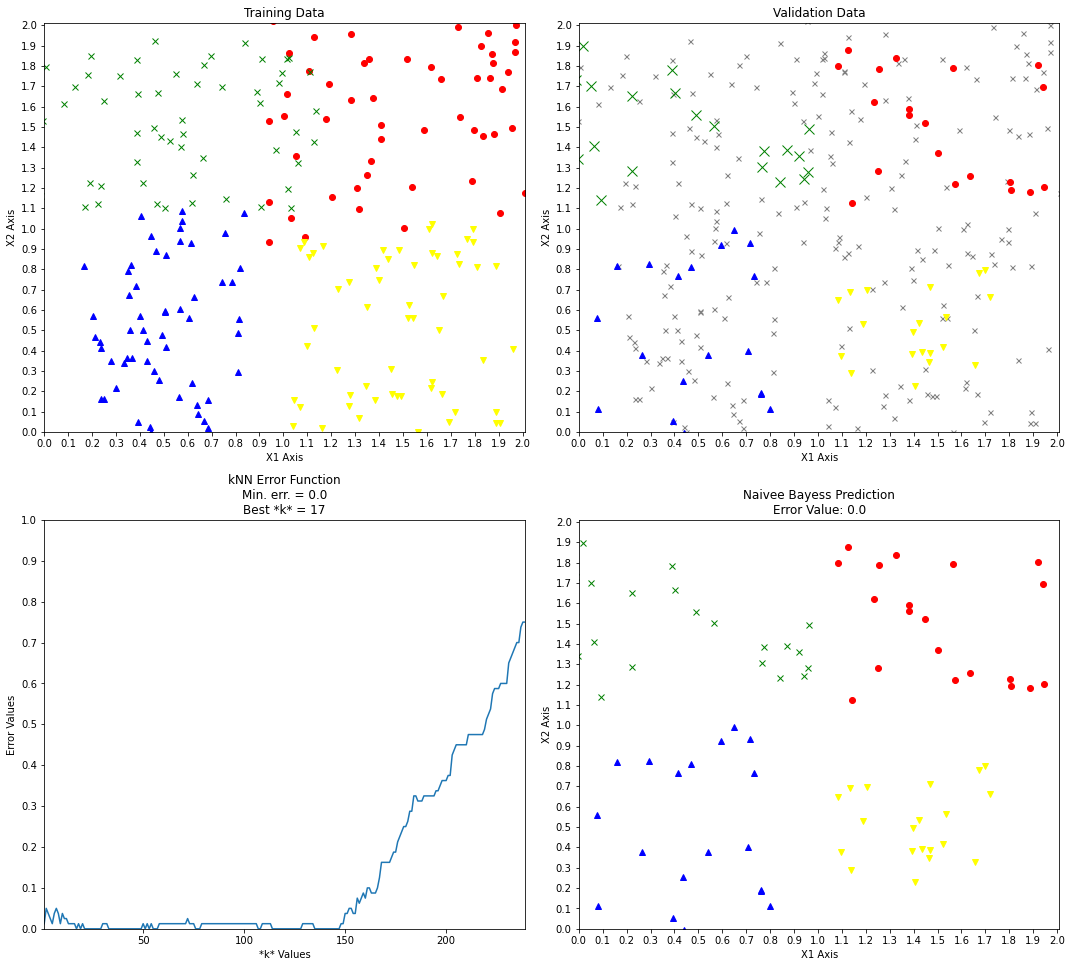

In [12]:
N_v = 20
N_t = 60
training_data = standard_data_generator(N_t, 0.7)
validation_data = standard_data_generator(N_v, 0.6)
fig = plt.figure(figsize=(15, 20))
plot_training_data_only(training_data, 1, N_t)
plot_validation_data(training_data, validation_data, 2, N_t, N_v)
plot_knn_errors(training_data, validation_data, 3)
plot_naive_bayess(training_data, validation_data, 4)
plt.tight_layout()
plt.draw()

# -------------------------------------------UnitTests -------------------------------------------

In [13]:
x1_train = np.array([[1],[1],[4],[2],[2],[-2],[-2],[-3],[-1],[-2]])
x2_train = np.array([[1],[2],[3],[2],[1],[1],[0],[1],[-1],[-2]])
y_train = np.array([[1]]*3 + [[2]]*3 + [[3]]*4)
x1_val = np.array([[3],[4],[1],[-1],[-1]])
x2_val = np.array([[1],[1],[0],[1],[0]])
y_val = np.array([[1]]*1 + [[2]]*1 + [[3]]*3)
N1 = 5
N2 = 10

def clac(x1v, x2v, x1t, x2t):
    return math.sqrt((x1v-x1t)**2 + (x2v - x2t)**2)

def expected_dists():
    expected = list()
    for v in range(N1):
        x1v = x1_val[v, 0]
        x2v = x2_val[v, 0]
        expected.append([clac(x1v,x2v,x1_train[t, 0],x2_train[t, 0]) for t in range(N2)])
    return np.array(expected)
    
class ModelsTests(unittest.TestCase):
    
    def test_knn_calculate_distance(self):
        answer = calculate_distance(x1_val.copy(), x2_val.copy(), x1_train.copy(), x2_train.copy())
        expected = expected_dists()
        self.assertEqual(expected.tolist(), answer.tolist())
        
    def test_knn_sort_distances(self):
        answer = sort_distances(expected_dists(), y_train)
        self.assertEqual((N1, N2), answer.shape)

    def test_nb_a_priori(self):
        answer = a_prioi(y_train.copy())
        expected = np.array([0.3,0.3, 0.4])
        self.assertEqual(expected.tolist(),answer.tolist())

    def test_nb_means(self):
        #answer = calculate_means(x1_train.copy(), x2_train.copy(), y_train.copy())
        #expected = np.array([[2.0, 0.6666666666666666, -2.0], [2.0, 1.3333333333333333, -0.5]])
        #self.assertEqual(expected.tolist(),answer.tolist())
        pass
        
    def test_nb_variance(self):
        #answer = calculate_variance(x1_train.copy(), x2_train.copy(), y_train.copy())
        #expected = np.array([[1.2, 0.4],[0.56, 1.36]])
        #self.assertEqual(expected.tolist(),answer.tolist())
        pass
    
    def test_nb_distr(self):
        #mean = calculate_means(x1_train.copy(), x2_train.copy(), y_train.copy())
        #variance = calculate_variance(x1_train.copy(), x2_train.copy(), y_train.copy())
        #answer = distr(x1_train.copy(), x2_train.copy(), mean, variance)
        #expected = np.array([0,0,0,0])
        #self.assertEqual(expected.tolist(),answer.tolist())
        pass

In [14]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_knn_calculate_distance (__main__.ModelsTests) ... ok
test_knn_sort_distances (__main__.ModelsTests) ... ok
test_nb_a_priori (__main__.ModelsTests) ... ok
test_nb_distr (__main__.ModelsTests) ... ok
test_nb_means (__main__.ModelsTests) ... ok
test_nb_variance (__main__.ModelsTests) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.006s

OK


In [15]:
def conc(xs):
    m = xs.shape[0]
    x1 = xs[:, 0].reshape((m,1))
    x2 = xs[:, 1].reshape((m,1))
    ones = np.ones((m,1))
    res = np. concatenate((ones,x1,x2,x1*x2), axis=1)
    print(res)
    
a = np.array([1,2,3,4,5]).reshape((5,1))
b = np.array([6,7,8,9,10]).reshape((5,1))
print(a, b)

conc(np.concatenate((a,b), axis=1))


[[1]
 [2]
 [3]
 [4]
 [5]] [[ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ 1.  1.  6.  6.]
 [ 1.  2.  7. 14.]
 [ 1.  3.  8. 24.]
 [ 1.  4.  9. 36.]
 [ 1.  5. 10. 50.]]
